# Clustering on Embeddings of Track Names

Instead of clustering on the attributes of the dataset, this notebook explores the clustering on embeddings of the track names

In [1]:
import os
import sys

BASE_DIR = os.path.join(os.path.abspath(""), "..")
sys.path.insert(0, BASE_DIR)

from data.datasource import load_X_y

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from IPython.display import display
import pandas as pd
from time import time
from sentence_transformers import SentenceTransformer

/home/sebastian/Coding/anaconda3/envs/icds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the transformer model and encode the track names

In [3]:
model = SentenceTransformer('all-mpnet-base-v2')

In [4]:
X, y, df = load_X_y(os.path.join(BASE_DIR, "data", "SpotifyFeatures.csv"), sample_size=500)

In [5]:
embeddings = np.array(model.encode(df['track_name'].tolist()))

## Apply KMeans to the embeddings

Given the high dimensionality of the embeddings, the first trial run is done with KMeans

In [6]:
from sklearn.cluster import k_means

In [13]:
_, emb_labels, _ = k_means(X=embeddings, n_clusters=26, n_init='auto')

For reference, KMeans is also performed on the initial data

In [14]:
_, attr_labels, _ = k_means(X=X, n_clusters=26, n_init='auto')

## Evaluation

For evaluation, we will again use the Rand Index and the contigency matrix

### Rand Index

In [12]:
from sklearn.metrics import adjusted_rand_score

In [16]:
print(f'Embedding score: {adjusted_rand_score(labels_true=y[:,0], labels_pred=emb_labels)}')
print(f'Attribute score: {adjusted_rand_score(labels_true=y[:,0], labels_pred=attr_labels)}')

Embedding score: 0.05741860027266703
Attribute score: 0.07071871386901886


As can be seen above, using the track name embeddings does not improve overlap with the genres

### Contigency matrix

In [17]:
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

def plot_sorted_contigency(true_labels, predicted_labels):
    contingency = contingency_matrix(true_labels[:, 0], predicted_labels)
    
    # Sort the contigency matrix based on the highest cluster / genre overlap
    row_ind, col_ind = linear_sum_assignment(-contingency)
    contingency_sorted = contingency[row_ind, :]
    
    # Create a dataframe for the plot
    n_genres = df.genre.nunique()
    n_clusters = predicted_labels.max() + 1
    contingency_df = pd.DataFrame(np.transpose(contingency_sorted), 
                                  columns=list(df.genre.unique()), 
                                  index=[f'Cluster {i}' for i in range(n_clusters)])
    
    # Plot the result
    fig, ax = plt.subplots(figsize=(18, 24))
    sn.heatmap(contingency_df, annot=True, ax=ax, fmt=".0f", cmap="Blues")

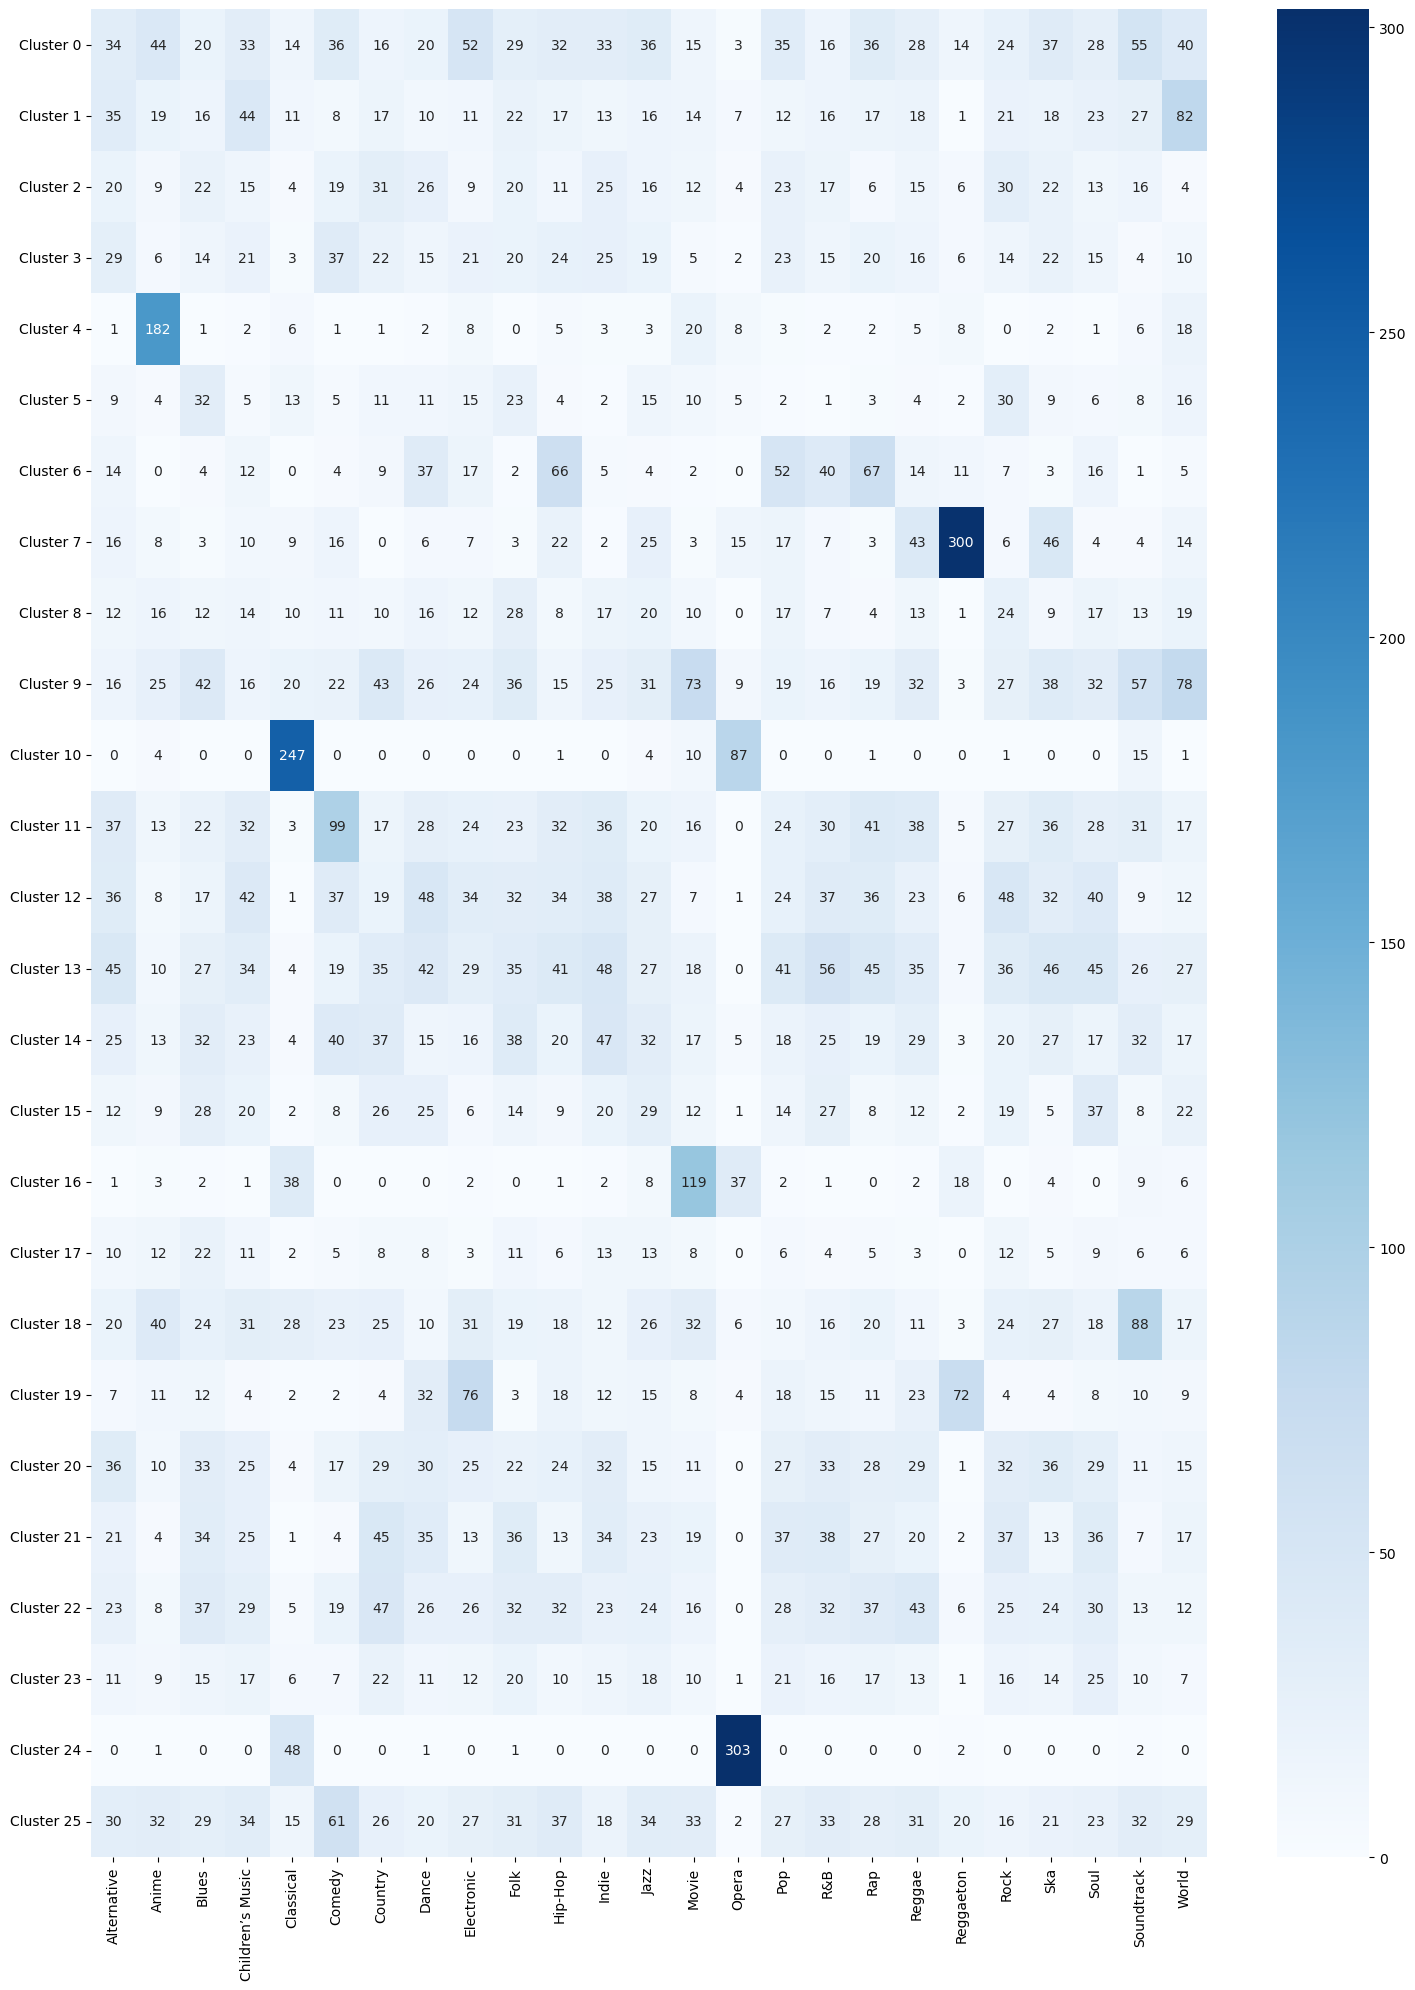

In [18]:
plot_sorted_contigency(y, emb_labels)

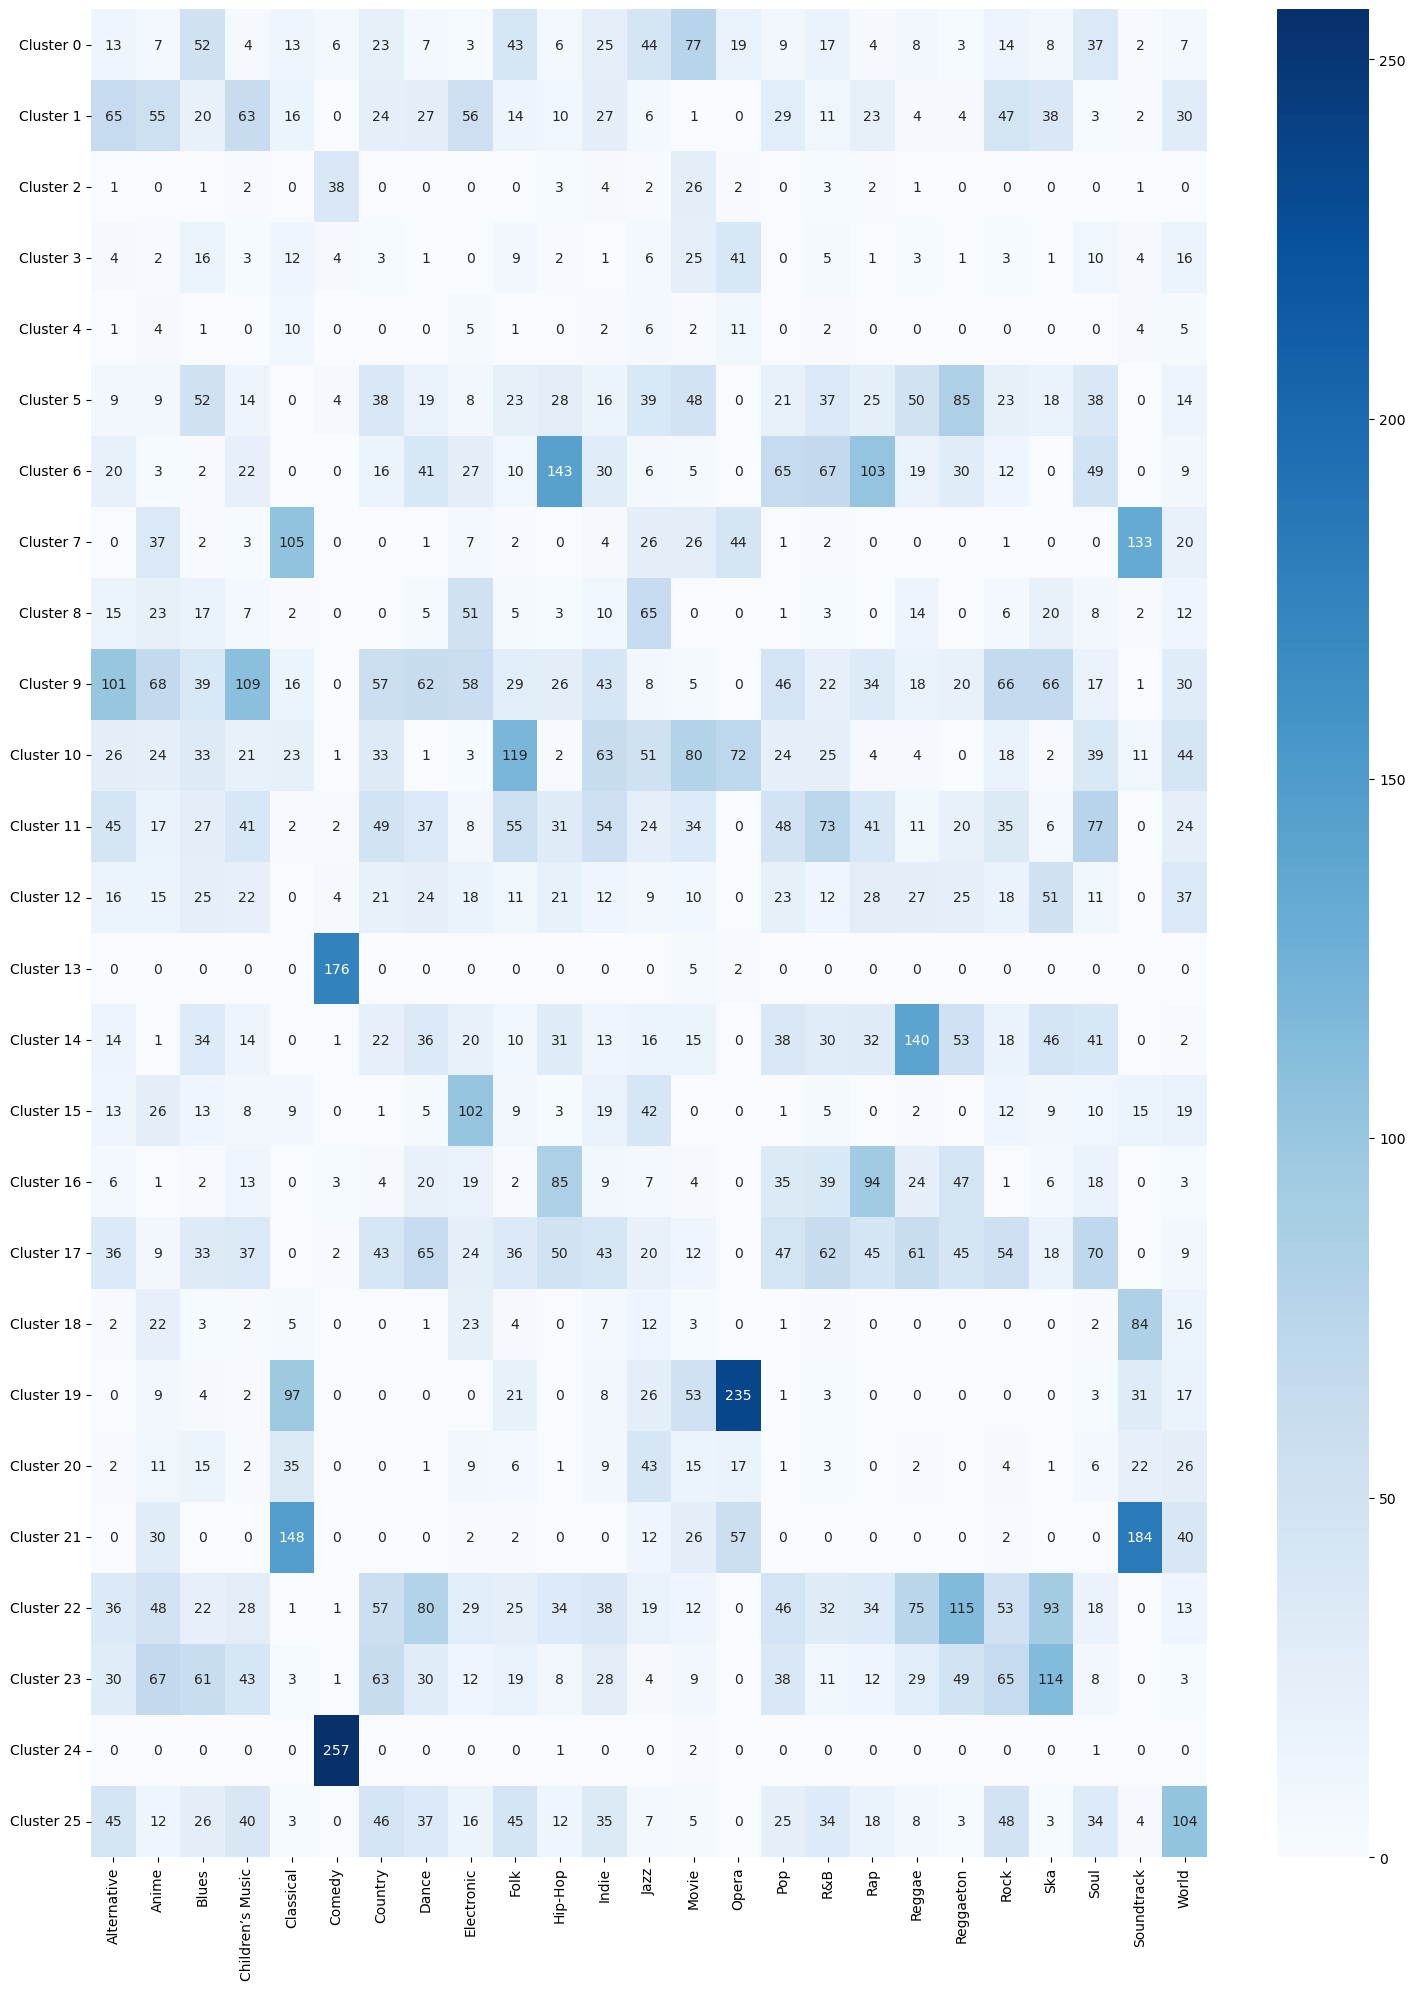

In [19]:
plot_sorted_contigency(y, attr_labels)

The results for the contigency matrix are more nuanced. Performing KMeans on the original attributes has some overlap with the genres, it creates only two "pronounced" clusters:
- Comedy and Cluster 24
- Opera and Cluster 19

KMeans on the embeddings, however, finds only four very pronounced clusters and nothing else:

- Anime and Cluster 4
- Classical and Cluster 10
- Opera and Cluster 24
- Reggaeton and Cluster 7

## Analysis

For Reggaeton, the strong clustering can be explained by the track_names being mostly in Spanish as seen below

In [22]:
df.loc[df['genre'] == 'Reggaeton', 'track_name'].iloc[:20]

159349                           Vivo
160053        No Te Ilusiones - Remix
139688                    El Telefono
158396                      Levemente
158676                Vete Pal Carajo
160542                        Tu Aire
139201        Reggaetón Lento (Remix)
165324                  Sera Tu Corte
160981           Pa Que la Pases Bien
164583                     Luna Llena
163894                         Twelve
158588                          Pegao
139358              Sígueme Y Te Sigo
164435            Se Me Daña la Mente
160578    La Espera (feat. Nicky Jam)
159831                        Oh Dios
158689                     Ocean Park
160312                Flaca O Gordita
160128              No Te Sientas Mal
160375                     Juego de 3
Name: track_name, dtype: object

A similar outcome can be observed for Anime and Japanese

In [23]:
df.loc[df['genre'] == 'Anime', 'track_name'].iloc[:20]

32907                          チェリー feat.佐々木萌 (エドガー・サリヴァン)
28365                                  Fisherman's Horizon
32204                                     Light of Destiny
29696                                       meditation app
32707                                               Signal
31417                            Onegai!Kon kon Oinarisama
34438                                            Invisible
28743                                    Stars in the Rain
35512                                             Terminal
35541    Baby, God Bless You - TBS系 金曜ドラマ「コウノドリ」(2015)メ...
33270                                                 ワンダー
31671    Timely Ambush (from FFVII 'Let the Battles Beg...
35121                                            輩(ルビ:やから)
32083                                         Dive to Blue
28056                                      Guren No Yumiya
34330                                 Don't Kill My Melody
30899                                           From Jap

The same is true for Opera and Italian

In [26]:
df.loc[df['genre'] == 'Opera', 'track_name'].iloc[:20]

106545    Cavalli / Arr Pluhar: L'Artemisia, Act 2: "Aff...
107558    Verdi : La Traviata : Act 1 "Si ridesta in cie...
106754                                                Mamma
79941     La fille du régiment / Act 2: Entr'acte ... En...
81626     La Cenerentola / Act 2: "Nacqui all'affanno e ...
105597    Dinorah, Act III: Act III Scene 1: Bref, nous ...
82737     Rigoletto / Act 3: È amabile invero cotal giov...
58354                           Macbeth, Act III: Ballabile
80226     I vespri siciliani: O tu, Palermo, terra adora...
81213              Rigoletto / Act 1: "E il sol dell'anima"
106418    Lucia di Lammermoor, Act I, Scene I: No. 2b La...
57709                             "Libiamo ne'lieti calici"
59131                        Alcina: "Tornami a vagheggiar"
106455             Ich Hab' Ihn Nicht Einmal Geküsst 1. Akt
59162                          Il Trovatore: Di quella pira
80846     Giselle (1996 Digital Remaster), Act II: No.14...
106749                                  

For classical music, the effect is not as strong

In [27]:
df.loc[df['genre'] == 'Classical', 'track_name'].iloc[:20]

128500              La Nativité du Seigneur: 2. Les Bergers
124350                                 Elgar: Salut d'amour
123650    Rinaldo, HWV 7a, Act III (Ed. G. Sechi): Mori ...
128165                  The Sussex Mummers' Christmas Carol
105310               Morceaux de Fantaisie, Op.3: 1. Elégie
104178    Die Entführung aus dem Serail, K. 384, Act III...
123778                       Maria - From "West Side Story"
130570    Concerto for 2 Pianos in A-Flat Minor, Op. 88a...
105012    Le Carnaval des Animaux, R.125: 13. The Swan (...
129543    Bach: Cello Suite No. 1 in G Major, BWV 1007: ...
127886        Symphony No.2 in B minor: 4. Finale (Allegro)
126791                   Union Station (800 N. Alameda St.)
124584    Kinderszenen, Op. 15: I. Von fremden Ländern u...
125978    Roméo et Juliette, CG 9 / Act 1: "Ah, je veux ...
129782    Swan Lake, Op. 20, Act II No. 13, Danses des c...
127100    Negro Folksongs in Counterpoint: No. 5, Swing ...
125853                       The Flower 

## Multilingual model

In order to assess the effect of language on the embeddings, a second, multlingual model will be used

In [29]:
ml_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [30]:
ml_embeddings = np.array(ml_model.encode(df['track_name'].tolist()))

In [31]:
_, ml_emb_labels, _ = k_means(X=ml_embeddings, n_clusters=26, n_init='auto')

### Evaluation

In [32]:
print(f'Multilingual embedding score: {adjusted_rand_score(labels_true=y[:,0], labels_pred=ml_emb_labels)}')

Multilingual embedding score: 0.038429468135427775


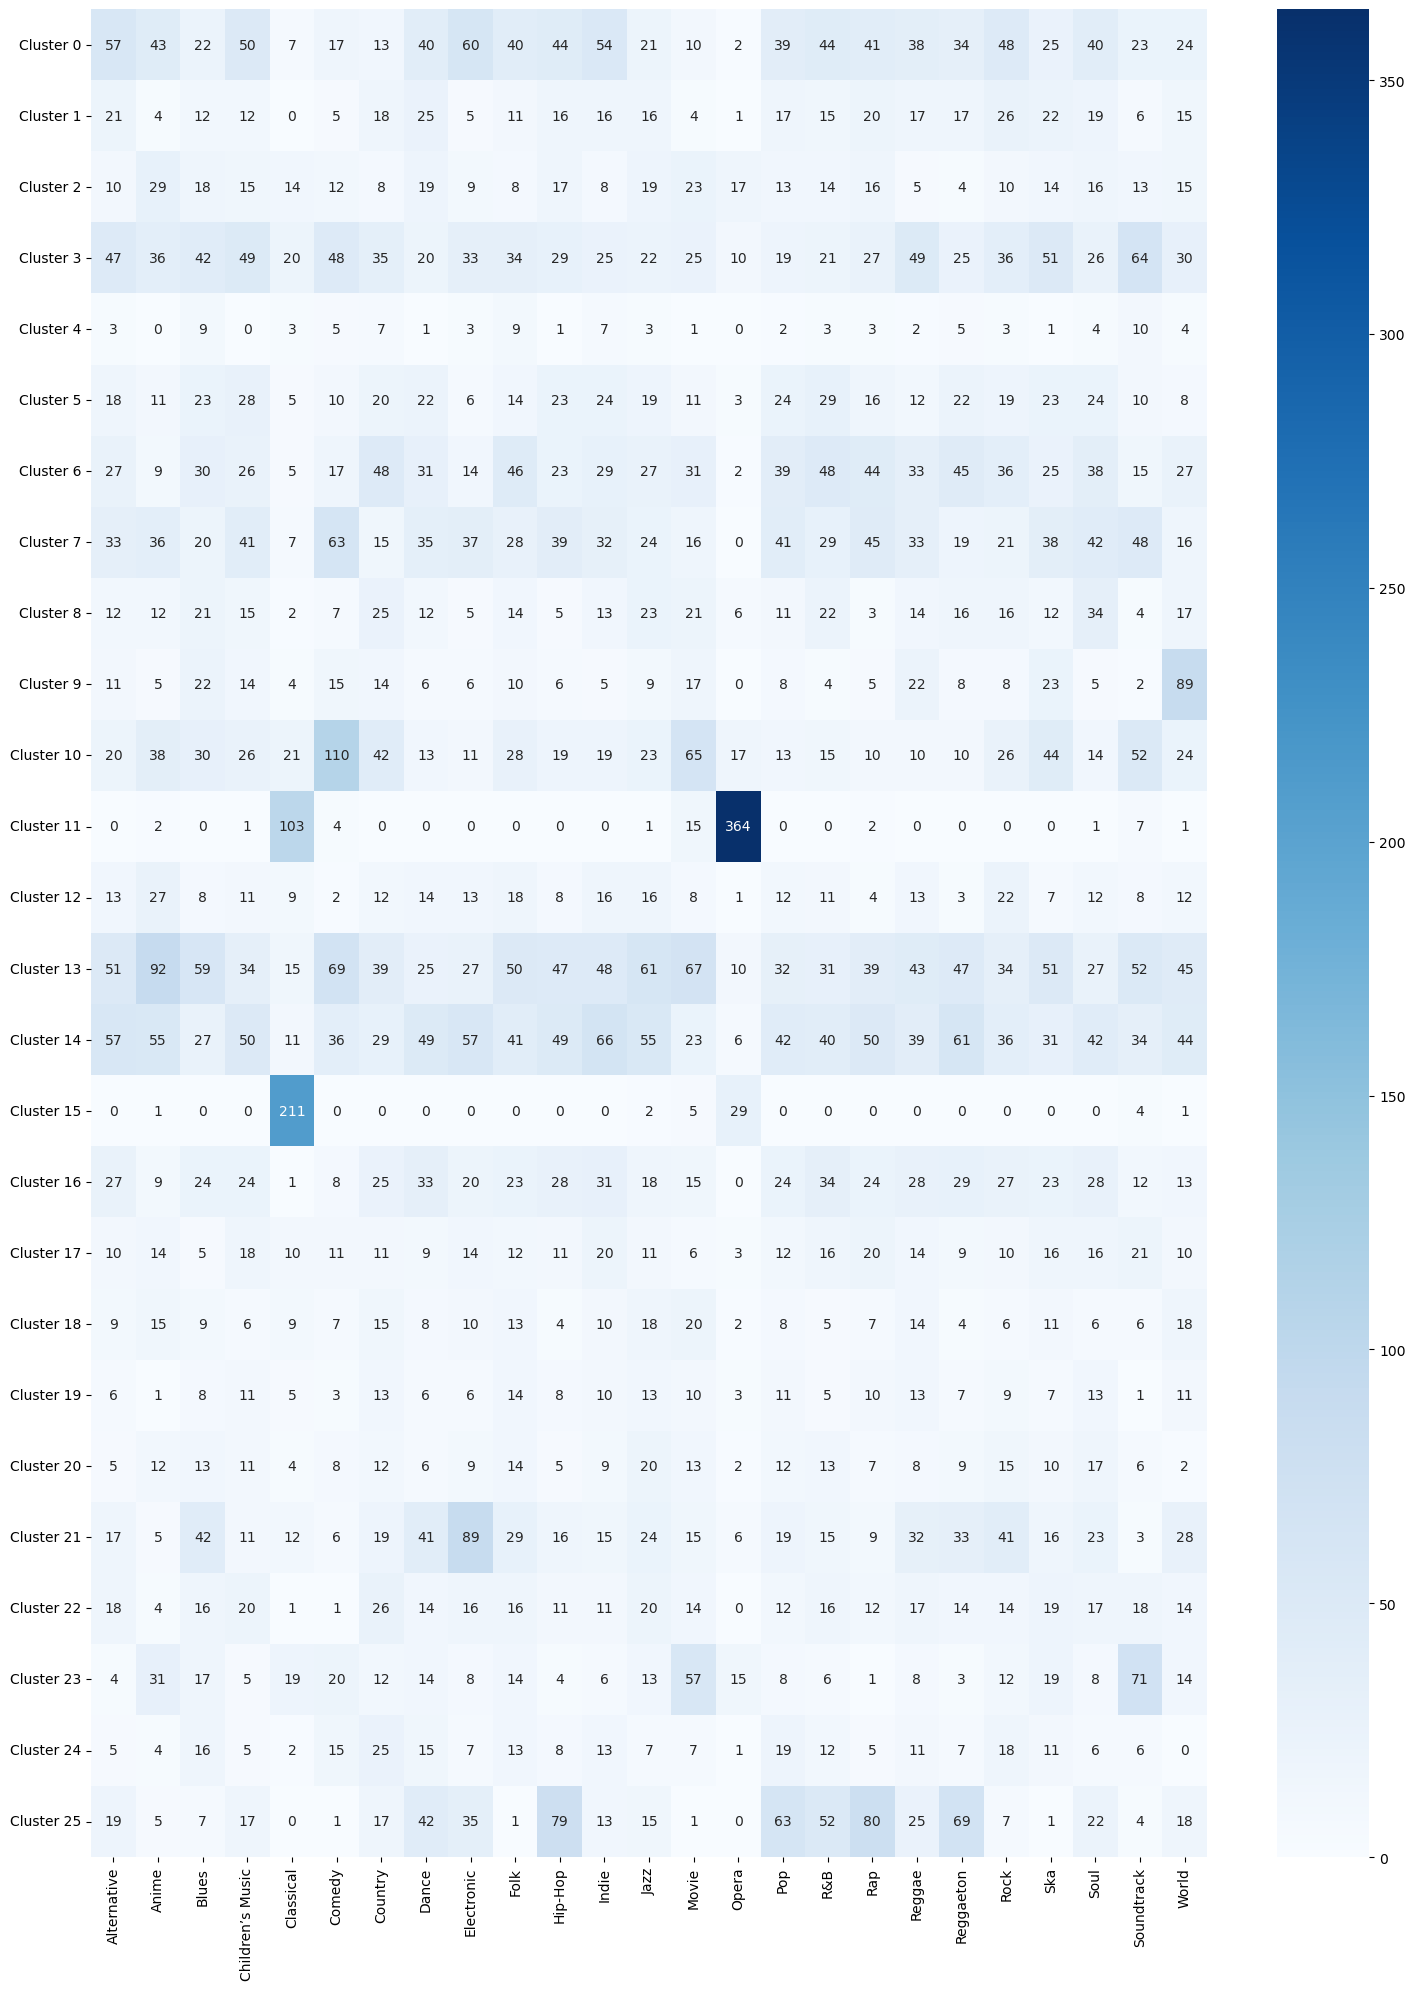

In [33]:
plot_sorted_contigency(y, ml_emb_labels)

As expected from the analysis above, "removing" the language component, by only clustering on the semantics of the track name, instead of effects due to different languages, results in worse performance.

Now only Classical and Opera songs receive pronounced clusters, suggesting that the genres semantic content is similar across songs.